In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime, timedelta
import requests
from io import StringIO
import time
from uuid import uuid4  # Para generar códigos únicos
import seaborn as sns
from IUCN_API.modules.Groups import Groups

In [2]:
# Descargar de cornell los nombres cientificos de las aves
url = "https://www.birds.cornell.edu/clementschecklist/wp-content/uploads/2024/10/Clements-v2024-October-2024-rev.csv"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)

if response.ok:
    lista = StringIO(response.text)
    df_tax = pd.read_csv(lista)
else:
    print("Error al descargar la taxonomía. Código HTTP:", response.status_code)

In [3]:
df_tax.columns

Index(['sort v2024', 'species_code', 'Clements v2024b change',
       'text for website v2024b', 'category', 'English name',
       'scientific name', 'range', 'order', 'family', 'extinct',
       'extinct year', 'sort_v2023'],
      dtype='object')

In [4]:
# Mostrar primeras filas de nombres comunes y científicos
df_species = df_tax[
    (df_tax['category'] == 'species') &
    df_tax[['order', 'family', 'scientific name', 'English name']].notna().all(axis=1)
][['order', 'family', 'scientific name', 'English name', 'category']]

In [5]:
df_species.columns

Index(['order', 'family', 'scientific name', 'English name', 'category'], dtype='object')

In [6]:
# Cargar todos los archivos de la red de directorios y generar un listado
base_dir = 'output/'
file_pattern = '*.BirdNET.selection.table.txt'  # Patrón de los archivos
df_list = []

# Recorrer todas las subcarpetas recursivamente
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.BirdNET.selection.table.txt'):  # Filtrar solo los archivos
            file_path = os.path.join(root, file)
            
            # Generar código único basado en rutas
            relative_path = os.path.relpath(file_path, base_dir)
            path_code = relative_path.replace(os.sep, '_')  # Ej: "quebracho_sem21_archivo.txt"
            unique_id = str(uuid4())[:8]  # Código alfanumérico corto (opcional)
            
            # Cargar archivo y añadir metadatos
            df = pd.read_csv(file_path, sep='\t')
            df['file_code'] = path_code  # Código basado en ruta
            df['unique_id'] = unique_id  # Código único universal
            df['source_path'] = relative_path  # Ruta relativa completa
            
            df_list.append(df)

# Consolidar
df_combined = pd.concat(df_list, ignore_index=True)

# Mostrar resultados
print(f"Se cargaron {len(df_list)} archivos. Total de registros: {len(df_combined)}")
print("\nEjemplo de códigos asignados:")
print(df_combined[['file_code', 'unique_id', 'source_path']].drop_duplicates().head())



Se cargaron 11351 archivos. Total de registros: 832753

Ejemplo de códigos asignados:
                                             file_code unique_id  \
0    semana19_MARTINICA_MARTINICA_20250511_124530.B...  9bb5decc   
1    semana19_MARTINICA_MARTINICA_20250511_160000.B...  2080bb4e   
43   semana19_MARTINICA_MARTINICA_20250511_162000.B...  9ea37dd0   
67   semana19_MARTINICA_MARTINICA_20250511_164000.B...  3608ccbd   
108  semana19_MARTINICA_MARTINICA_20250511_170000.B...  1bd16b47   

                                           source_path  
0    semana19/MARTINICA/MARTINICA_20250511_124530.B...  
1    semana19/MARTINICA/MARTINICA_20250511_160000.B...  
43   semana19/MARTINICA/MARTINICA_20250511_162000.B...  
67   semana19/MARTINICA/MARTINICA_20250511_164000.B...  
108  semana19/MARTINICA/MARTINICA_20250511_170000.B...  


In [7]:
df_combined.shape

(832753, 15)

In [8]:
df_combined.head()

Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1             0.0           3.0   
1          1  Spectrogram 1        1            15.0          18.0   
2          2  Spectrogram 1        1            51.0          54.0   
3          3  Spectrogram 1        1            63.0          66.0   
4          4  Spectrogram 1        1            69.0          72.0   

   Low Freq (Hz)  High Freq (Hz)          Common Name Species Code  \
0              0           15000               nocall       nocall   
1              0           15000  Clay-colored Thrush       clcrob   
2              0           15000  Clay-colored Thrush       clcrob   
3              0           15000  Clay-colored Thrush       clcrob   
4              0           15000  Clay-colored Thrush       clcrob   

   Confidence                                         Begin Path  \
0      1.0000  input/semana19/MARTINICA/MARTINICA_20250511_12...   
1      0.4770  input/semana19/MARTINICA/MARTINICA_20250511_16...   
2      0.2978  input/semana19/MARTINICA/MARTINICA_20250511_16...   
3      0.4253  input/semana19/MARTINICA/MARTINICA_20250511_16...   
4      0.4190  input/semana19/MARTINICA/MARTINICA_20250511_16...   

   File Offset (s)                                          file_code  \
0              0.0  semana19_MARTINICA_MARTINICA_20250511_124530.B...   
1             15.0  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
2             51.0  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
3             63.0  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
4             69.0  semana19_MARTINICA_MARTINICA_20250511_160000.B...   

  unique_id                                        source_path  
0  9bb5decc  semana19/MARTINICA/MARTINICA_20250511_124530.B...  
1  2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...  
2  2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...  
3  2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...  
4  2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...

In [9]:
df_combined.describe

<bound method NDFrame.describe of         Selection           View  Channel  Begin Time (s)  End Time (s)  \
0               1  Spectrogram 1        1             0.0           3.0   
1               1  Spectrogram 1        1            15.0          18.0   
2               2  Spectrogram 1        1            51.0          54.0   
3               3  Spectrogram 1        1            63.0          66.0   
4               4  Spectrogram 1        1            69.0          72.0   
...           ...            ...      ...             ...           ...   
832748        120  Spectrogram 1        1          1704.0        1707.0   
832749        121  Spectrogram 1        1          1713.0        1716.0   
832750        122  Spectrogram 1        1          1737.0        1740.0   
832751        123  Spectrogram 1        1          1740.0        1743.0   
832752        124  Spectrogram 1        1          1764.0        1767.0   

        Low Freq (Hz)  High Freq (Hz)          Common Name Specie

In [10]:
# Anadir los nombres en cientificos al df de datos 
df_merged = df_combined.merge(
    df_species,
    how='left',
    left_on='Common Name',      # de df_combined
    right_on='English name'     # de df_species
)

In [11]:
df_merged[['Genus', 'species']] = df_merged['scientific name'].str.strip().str.split(' ', n=1, expand=True)

In [12]:
df_merged.head()

Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1             0.0           3.0   
1          1  Spectrogram 1        1            15.0          18.0   
2          2  Spectrogram 1        1            51.0          54.0   
3          3  Spectrogram 1        1            63.0          66.0   
4          4  Spectrogram 1        1            69.0          72.0   

   Low Freq (Hz)  High Freq (Hz)          Common Name Species Code  \
0              0           15000               nocall       nocall   
1              0           15000  Clay-colored Thrush       clcrob   
2              0           15000  Clay-colored Thrush       clcrob   
3              0           15000  Clay-colored Thrush       clcrob   
4              0           15000  Clay-colored Thrush       clcrob   

   Confidence  ...                                          file_code  \
0      1.0000  ...  semana19_MARTINICA_MARTINICA_20250511_124530.B...   
1      0.4770  ...  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
2      0.2978  ...  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
3      0.4253  ...  semana19_MARTINICA_MARTINICA_20250511_160000.B...   
4      0.4190  ...  semana19_MARTINICA_MARTINICA_20250511_160000.B...   

   unique_id                                        source_path  \
0   9bb5decc  semana19/MARTINICA/MARTINICA_20250511_124530.B...   
1   2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...   
2   2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...   
3   2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...   
4   2080bb4e  semana19/MARTINICA/MARTINICA_20250511_160000.B...   

           order                          family scientific name  \
0            NaN                             NaN             NaN   
1  Passeriformes  Turdidae (Thrushes and Allies)    Turdus grayi   
2  Passeriformes  Turdidae (Thrushes and Allies)    Turdus grayi   
3  Passeriformes  Turdidae (Thrushes and Allies)    Turdus grayi   
4  Passeriformes  Turdidae (Thrushes and Allies)    Turdus grayi   

          English name category   Genus species  
0                  NaN      NaN     NaN     NaN  
1  Clay-colored Thrush  species  Turdus   grayi  
2  Clay-colored Thrush  species  Turdus   grayi  
3  Clay-colored Thrush  species  Turdus   grayi  
4  Clay-colored Thrush  species  Turdus   grayi  

[5 rows x 22 columns]

In [13]:
species_list=set(df_merged["Genus"].fillna("") + " " + df_merged["species"].fillna(""))
species_clean = set([s for s in species_list if s != " "])
#species_clean

In [14]:
## Descargar el estatus de IUCN

In [15]:
#Revisar si funciona el token

token = 'EP8VvgBLnPTxN4rfzmdUuYAn4rgMrCLDsE9v'
url = "https://api.iucnredlist.org/api/v4/information/api_version"
headers = {
    "Authorization": f"Bearer {token}"
}

response = requests.get(url, headers=headers)

print("Status code:", response.status_code, " #Si imprime 200 todo esta bien")

Status code: 200  #Si imprime 200 todo esta bien


In [16]:
#Descargar el status de IUCN y agregar a la lista

from tqdm import tqdm

token = 'EP8VvgBLnPTxN4rfzmdUuYAn4rgMrCLDsE9v' # Gestionar APIv4 en IUCN redlist
headers = {"Authorization": f"Bearer {token}"}

unique_combinations = df_merged[['Genus', 'species']].drop_duplicates()

results_cache = {}

for genus, species in tqdm(unique_combinations.values, desc="Querying IUCN"):
    cache_key = (genus, species)
    
    if cache_key not in results_cache:
        url = (
            "https://api.iucnredlist.org/api/v4/taxa/scientific_name"
            f"?genus_name={genus}&species_name={species}"
        )
        
        try:
            response = requests.get(url, headers=headers)
            results_cache[cache_key] = {
                'status_code': response.status_code,
                'data': response.json() if response.ok else response.text
            }
        except Exception as e:
            results_cache[cache_key] = {
                'status_code': 'Error',
                'data': str(e)
            }
        
        time.sleep(1)



Querying IUCN: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 367/367 [09:28<00:00,  1.55s/it]


Querying IUCN:   1%|█▊                                                                                                                                                       | 1/82 [00:01<02:38,  1.96s/it]

Querying IUCN:   2%|███▋                                                                                                                                                     | 2/82 [00:03<02:21,  1.77s/it]

Querying IUCN:   4%|█████▌                                                                                                                                                   | 3/82 [00:05<02:33,  1.94s/it]

Querying IUCN:   5%|███████▍                                                                                                                                                 | 4/82 [00:07<02:25,  1.86s/it]

Querying IUCN:   6%|█████████▎                                                                                                                                               | 5/82 [00:09<02:25,  1.89s/it]

Querying IUCN:   7%|███████████▏                                                                                                                                             | 6/82 [00:11<02:17,  1.81s/it]

Querying IUCN:   9%|█████████████                                                                                                                                            | 7/82 [00:12<02:11,  1.75s/it]

Querying IUCN:  10%|██████████████▉                                                                                                                                          | 8/82 [00:14<02:06,  1.72s/it]

Querying IUCN:  11%|████████████████▊                                                                                                                                        | 9/82 [00:15<02:03,  1.69s/it]

Querying IUCN:  12%|██████████████████▌                                                                                                                                     | 10/82 [00:17<02:02,  1.71s/it]

Querying IUCN:  13%|████████████████████▍                                                                                                                                   | 11/82 [00:19<01:57,  1.66s/it]

Querying IUCN:  15%|██████████████████████▏                                                                                                                                 | 12/82 [00:20<01:55,  1.65s/it]

Querying IUCN:  16%|████████████████████████                                                                                                                                | 13/82 [00:22<01:55,  1.68s/it]

Querying IUCN:  17%|█████████████████████████▉                                                                                                                              | 14/82 [00:24<01:55,  1.70s/it]

Querying IUCN:  18%|███████████████████████████▊                                                                                                                            | 15/82 [00:26<01:54,  1.71s/it]

Querying IUCN:  20%|█████████████████████████████▋                                                                                                                          | 16/82 [00:27<01:51,  1.69s/it]

Querying IUCN:  21%|███████████████████████████████▌                                                                                                                        | 17/82 [00:29<01:48,  1.67s/it]

Querying IUCN:  22%|█████████████████████████████████▎                                                                                                                      | 18/82 [00:31<01:46,  1.67s/it]

Querying IUCN:  23%|███████████████████████████████████▏                                                                                                                    | 19/82 [00:32<01:44,  1.65s/it]

Querying IUCN:  24%|█████████████████████████████████████                                                                                                                   | 20/82 [00:34<01:41,  1.64s/it]

Querying IUCN:  26%|██████████████████████████████████████▉                                                                                                                 | 21/82 [00:35<01:40,  1.65s/it]

Querying IUCN:  27%|████████████████████████████████████████▊                                                                                                               | 22/82 [00:37<01:38,  1.65s/it]

Querying IUCN:  28%|██████████████████████████████████████████▋                                                                                                             | 23/82 [00:39<01:36,  1.64s/it]

Querying IUCN:  29%|████████████████████████████████████████████▍                                                                                                           | 24/82 [00:41<01:40,  1.73s/it]

Querying IUCN:  30%|██████████████████████████████████████████████▎                                                                                                         | 25/82 [00:42<01:37,  1.71s/it]

Querying IUCN:  32%|████████████████████████████████████████████████▏                                                                                                       | 26/82 [00:44<01:34,  1.69s/it]

Querying IUCN:  33%|██████████████████████████████████████████████████                                                                                                      | 27/82 [00:46<01:30,  1.65s/it]

Querying IUCN:  34%|███████████████████████████████████████████████████▉                                                                                                    | 28/82 [00:47<01:28,  1.64s/it]

Querying IUCN:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 29/82 [00:49<01:30,  1.70s/it]

Querying IUCN:  37%|███████████████████████████████████████████████████████▌                                                                                                | 30/82 [00:51<01:28,  1.71s/it]

Querying IUCN:  38%|█████████████████████████████████████████████████████████▍                                                                                              | 31/82 [00:52<01:26,  1.69s/it]

Querying IUCN:  39%|███████████████████████████████████████████████████████████▎                                                                                            | 32/82 [00:54<01:25,  1.70s/it]

Querying IUCN:  40%|█████████████████████████████████████████████████████████████▏                                                                                          | 33/82 [00:56<01:22,  1.69s/it]

Querying IUCN:  41%|███████████████████████████████████████████████████████████████                                                                                         | 34/82 [00:57<01:21,  1.70s/it]

Querying IUCN:  43%|████████████████████████████████████████████████████████████████▉                                                                                       | 35/82 [00:59<01:19,  1.68s/it]

Querying IUCN:  44%|██████████████████████████████████████████████████████████████████▋                                                                                     | 36/82 [01:01<01:18,  1.70s/it]

Querying IUCN:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 37/82 [01:02<01:15,  1.68s/it]

Querying IUCN:  46%|██████████████████████████████████████████████████████████████████████▍                                                                                 | 38/82 [01:04<01:13,  1.67s/it]

Querying IUCN:  48%|████████████████████████████████████████████████████████████████████████▎                                                                               | 39/82 [01:06<01:12,  1.69s/it]

Querying IUCN:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                             | 40/82 [01:08<01:10,  1.67s/it]

Querying IUCN:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 41/82 [01:09<01:08,  1.66s/it]

Querying IUCN:  51%|█████████████████████████████████████████████████████████████████████████████▊                                                                          | 42/82 [01:11<01:06,  1.66s/it]

Querying IUCN:  52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 43/82 [01:12<01:04,  1.65s/it]

Querying IUCN:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                      | 44/82 [01:14<01:02,  1.65s/it]

Querying IUCN:  55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                    | 45/82 [01:16<01:00,  1.64s/it]

Querying IUCN:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 46/82 [01:17<00:59,  1.64s/it]

Querying IUCN:  57%|███████████████████████████████████████████████████████████████████████████████████████                                                                 | 47/82 [01:19<00:57,  1.64s/it]

Querying IUCN:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 48/82 [01:21<00:55,  1.62s/it]

Querying IUCN:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 49/82 [01:22<00:53,  1.62s/it]

Querying IUCN:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 50/82 [01:24<00:51,  1.62s/it]

Querying IUCN:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 51/82 [01:25<00:49,  1.61s/it]

Querying IUCN:  63%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 52/82 [01:27<00:49,  1.64s/it]

Querying IUCN:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 53/82 [01:29<00:47,  1.64s/it]

Querying IUCN:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 54/82 [01:30<00:45,  1.64s/it]

Querying IUCN:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 55/82 [01:32<00:45,  1.67s/it]

Querying IUCN:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 56/82 [01:34<00:43,  1.66s/it]

Querying IUCN:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 57/82 [01:35<00:41,  1.65s/it]

Querying IUCN:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 58/82 [01:37<00:39,  1.65s/it]

Querying IUCN:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 59/82 [01:39<00:38,  1.68s/it]

Querying IUCN:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 60/82 [01:40<00:36,  1.67s/it]

Querying IUCN:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 61/82 [01:42<00:34,  1.66s/it]

Querying IUCN:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 62/82 [01:44<00:33,  1.65s/it]

Querying IUCN:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 63/82 [01:45<00:31,  1.65s/it]

Querying IUCN:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 64/82 [01:47<00:29,  1.65s/it]

Querying IUCN:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 65/82 [01:49<00:28,  1.67s/it]

Querying IUCN:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 66/82 [01:50<00:26,  1.66s/it]

Querying IUCN:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 67/82 [01:52<00:25,  1.69s/it]

Querying IUCN:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 68/82 [01:54<00:23,  1.66s/it]

Querying IUCN:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 69/82 [01:55<00:21,  1.66s/it]

Querying IUCN:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 70/82 [01:57<00:19,  1.66s/it]

Querying IUCN:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 71/82 [01:59<00:18,  1.65s/it]

Querying IUCN:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 72/82 [02:00<00:16,  1.65s/it]

Querying IUCN:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 73/82 [02:02<00:14,  1.64s/it]

Querying IUCN:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 74/82 [02:04<00:13,  1.64s/it]

Querying IUCN:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 75/82 [02:05<00:11,  1.64s/it]

Querying IUCN:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 76/82 [02:07<00:10,  1.67s/it]

Querying IUCN:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 77/82 [02:09<00:08,  1.66s/it]

Querying IUCN:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 78/82 [02:10<00:06,  1.65s/it]

Querying IUCN:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 79/82 [02:12<00:05,  1.68s/it]

Querying IUCN:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 80/82 [02:14<00:03,  1.70s/it]

Querying IUCN:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 81/82 [02:16<00:01,  1.74s/it]

Querying IUCN: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:17<00:00,  1.77s/it]

Querying IUCN: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:17<00:00,  1.68s/it]

In [17]:
# Revisar el objeto JSON
results_cache

{(nan, nan): {'status_code': 404, 'data': '{"error":"Not found"}'},
 ('Turdus', 'grayi'): {'status_code': 200,
  'data': {'taxon': {'sis_id': 22708914,
    'scientific_name': 'Turdus grayi',
    'species_taxa': [],
    'subpopulation_taxa': [],
    'infrarank_taxa': [],
    'kingdom_name': 'ANIMALIA',
    'phylum_name': 'CHORDATA',
    'class_name': 'AVES',
    'order_name': 'PASSERIFORMES',
    'family_name': 'TURDIDAE',
    'genus_name': 'Turdus',
    'species_name': 'grayi',
    'subpopulation_name': None,
    'infra_name': None,
    'authority': 'Bonaparte, 1838',
    'species': True,
    'subpopulation': False,
    'infrarank': False,
    'ssc_groups': [{'name': 'IUCN SSC Bird Red List Authority (BirdLife International)',
      'url': 'https://www.birdlife.org/',
      'description': 'Red List Authority Coordinator: Ian Burfield (ian.burfield@birdlife.org)'}],
    'common_names': [{'main': False,
      'name': 'Clay-colored Robin',
      'language': 'eng'},
     {'main': False, 'n

In [51]:
# Colocar los resultados en el DataFrame original
def get_cached_result(row):
    return results_cache.get((row['Genus'], row['species']), 
           {'status_code': 'Missing', 'data': None})

df_merged['IUCN_status'] = df_merged.apply(lambda x: get_cached_result(x)['status_code'], axis=1)
df_merged['IUCN_response'] = df_merged.apply(lambda x: get_cached_result(x)['data'], axis=1)

def get_red_list_category(row):
    result = get_cached_result(row)['data']
    
    # Convertir string JSON a dict si es necesario
    import json
    if isinstance(result, str):
        try:
            result = json.loads(result)
        except Exception:
            return None
    
    if isinstance(result, dict):
        assessments = result.get('assessments', [])
        # Filtrar la evaluación más reciente
        for a in assessments:
            if a.get('latest'):
                return a.get('red_list_category_code')
    return None


results_df = pd.DataFrame([
    {'Genus': k[0], 'Species': k[1], **v} 
    for k, v in results_cache.items()
])

In [58]:
# Imprimir el estatus de los datos guardados en el paso anterior
import json

for idx, row in results_df.iterrows():
    print(f"\n--- Row {idx} ---")
    if isinstance(row['data'], dict):
        print(json.dumps(row['data'], indent=4))
    else:
        print(row['data'])
# Extraer el estatus de los datos guardados en el paso anterior
def get_iucn_status(data):
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except:
            pass
    if isinstance(data, dict):
        if "error" in data and data["error"] == "Not found":
            return "Not_IUCN"
        
        if "assessments" in data:  
            assessments = data["assessments"]
        elif "assessments" in data:  
            assessments = data["assessments"]
        else:
            return "Not_IUCN"
            
        for assessment in assessments:
            if assessment.get("latest"):
                return assessment.get("red_list_category_code", "Not_IUCN")
    
    return "Not_IUCN"

# Aplicar la funcion para crear una nueva columna
results_df['IUCN_category'] = results_df['data'].apply(get_iucn_status)

print(results_df[['scientific name','Genus', 'Species', 'IUCN_category']])


--- Row 0 ---
{"error":"Not found"}

--- Row 1 ---
{
    "taxon": {
        "sis_id": 22708914,
        "scientific_name": "Turdus grayi",
        "species_taxa": [],
        "subpopulation_taxa": [],
        "infrarank_taxa": [],
        "kingdom_name": "ANIMALIA",
        "phylum_name": "CHORDATA",
        "class_name": "AVES",
        "order_name": "PASSERIFORMES",
        "family_name": "TURDIDAE",
        "genus_name": "Turdus",
        "species_name": "grayi",
        "subpopulation_name": null,
        "infra_name": null,
        "authority": "Bonaparte, 1838",
        "species": true,
        "subpopulation": false,
        "infrarank": false,
        "ssc_groups": [
            {
                "name": "IUCN SSC Bird Red List Authority (BirdLife International)",
                "url": "https://www.birdlife.org/",
                "description": "Red List Authority Coordinator: Ian Burfield (ian.burfield@birdlife.org)"
            }
        ],
        "common_names": [
       

KeyError: "['scientific name'] not in index"

In [19]:
df_merged['IUCN_red_list_category'] = df_merged.apply(get_red_list_category, axis=1)

In [20]:
df_merged['hora'] = df_merged['source_path'].str.extract(r'^[^_]+_[^_]+_([^\.]+)')
df_merged['hora'] = df_merged['hora'].str[:-2]
df_merged['hora'] = pd.to_numeric(df_merged['hora'], errors='coerce')
df_merged['actividad'] = np.where(
    (df_merged['hora'] > 530) & (df_merged['hora'] < 1830),
    'diurna',
    'nocturna'
)


In [21]:
df_merged['recorder'] = df_merged['source_path'].str.extract(r'^[^_]+/[^_]+/([^\_]+)') #agregar nombre de grabadoras

In [22]:
sorted(df_merged['recorder'].dropna().unique()) #ver grabadoras

['2MM04962',
 '2MM04989',
 '2MM05044',
 '2MM05057',
 '2MM05099',
 '2MM05124',
 '2MM05127',
 '2MM05175',
 '2MM05210',
 '2MM05217',
 '2MM05221',
 '2MM05228',
 '2MM05240',
 'MARTINICA']

In [23]:
# Corregir nombres de grabadoras
df_merged['recorder'] = df_merged['recorder'].str.replace(
    'MARTINICA',        # cadena a buscar
    '2MM05175',       # cadena nueva
    regex=False          
)
df_merged['recorder'] = df_merged['recorder'].str.replace(
    '2MM05217',        # cadena a buscar
    '2MM05175',       # cadena nueva
    regex=False          
)

In [24]:
sorted(df_merged['recorder'].dropna().unique()) #Visualizar cambios de nombres

['2MM04962',
 '2MM04989',
 '2MM05044',
 '2MM05057',
 '2MM05099',
 '2MM05124',
 '2MM05127',
 '2MM05175',
 '2MM05210',
 '2MM05221',
 '2MM05228',
 '2MM05240']

In [25]:
# Agregar datos a las grabadoras.

# '2MM04962',14.446105 -89.697296 La Tuna poza
df_merged.loc[df_merged['recorder'] == '2MM04962', 'lugar'] = 'La Tuna'
df_merged.loc[df_merged['recorder'] == '2MM04962', 'lugar2'] = 'poza bosque'
df_merged.loc[df_merged['recorder'] == '2MM04962', 'codigo'] = 'LTpoz'
df_merged.loc[df_merged['recorder'] == '2MM04962', 'y'] =  14.446105
df_merged.loc[df_merged['recorder'] == '2MM04962', 'x'] = -89.697296

# '2MM04989',14.439436 -89.701372 La Tuna potrero
df_merged.loc[df_merged['recorder'] == '2MM04989', 'lugar'] = 'La Tuna'
df_merged.loc[df_merged['recorder'] == '2MM04989', 'lugar2'] = 'potrero'
df_merged.loc[df_merged['recorder'] == '2MM04989', 'codigo'] = 'LTpot'
df_merged.loc[df_merged['recorder'] == '2MM04989', 'y'] = 14.439436
df_merged.loc[df_merged['recorder'] == '2MM04989', 'x'] = -89.701372

# '2MM05044',14.416121 -89.768584 Quebracho1
df_merged.loc[df_merged['recorder'] == '2MM05044', 'lugar'] = 'Suchitan'
df_merged.loc[df_merged['recorder'] == '2MM05044', 'lugar2'] = 'abajo'
df_merged.loc[df_merged['recorder'] == '2MM05044', 'codigo'] = 'SUCab'
df_merged.loc[df_merged['recorder'] == '2MM05044', 'y'] = 14.416121
df_merged.loc[df_merged['recorder'] == '2MM05044', 'x'] = -89.768584

# '2MM05057',14.51 Quebracho2
df_merged.loc[df_merged['recorder'] == '2MM05057', 'lugar'] = 'Suchitan'
df_merged.loc[df_merged['recorder'] == '2MM05057', 'lugar2'] = 'arriba'
df_merged.loc[df_merged['recorder'] == '2MM05057', 'codigo'] = 'SUCar'
df_merged.loc[df_merged['recorder'] == '2MM05057', 'y'] = 0
df_merged.loc[df_merged['recorder'] == '2MM05057', 'x'] = 0

# '2MM05099',14.4615962 -89.7232990 Catocha
df_merged.loc[df_merged['recorder'] == '2MM05099', 'lugar'] = 'Catocha'
df_merged.loc[df_merged['recorder'] == '2MM05099', 'lugar2'] = 'potrero'
df_merged.loc[df_merged['recorder'] == '2MM05099', 'codigo'] = 'CATp'
df_merged.loc[df_merged['recorder'] == '2MM05099', 'y'] = 14.4615962
df_merged.loc[df_merged['recorder'] == '2MM05099', 'x'] = -89.7232990

# '2MM05124',14.517374 -89.643434 Agua Blanca
df_merged.loc[df_merged['recorder'] == '2MM05124', 'lugar'] = 'Agua Blanca'
df_merged.loc[df_merged['recorder'] == '2MM05124', 'lugar'] = 'abajo'
df_merged.loc[df_merged['recorder'] == '2MM05124', 'codigo'] = 'ABab'
df_merged.loc[df_merged['recorder'] == '2MM05124', 'y'] = 14.517374
df_merged.loc[df_merged['recorder'] == '2MM05124', 'x'] = -89.643434

# '2MM05127',14.312703 -89.655425 Martinica potrero
df_merged.loc[df_merged['recorder'] == '2MM05127', 'lugar'] = 'Martinica'
df_merged.loc[df_merged['recorder'] == '2MM05127', 'lugar2'] = 'potrero'
df_merged.loc[df_merged['recorder'] == '2MM05127', 'codigo'] = 'MARp'
df_merged.loc[df_merged['recorder'] == '2MM05127', 'y'] = 14.312703
df_merged.loc[df_merged['recorder'] == '2MM05127', 'x'] = -89.655425

# '2MM05175',14.313815 -89.651641 Martinica (nueva) = '2MM05217'(se arruino) 
df_merged.loc[df_merged['recorder'] == '2MM05175', 'lugar'] = 'Martinica'
df_merged.loc[df_merged['recorder'] == '2MM05175', 'lugar2'] = 'bosque'
df_merged.loc[df_merged['recorder'] == '2MM05175', 'codigo'] = 'MARb'
df_merged.loc[df_merged['recorder'] == '2MM05175', 'y'] = 14.313815
df_merged.loc[df_merged['recorder'] == '2MM05175', 'x'] = -89.651641

# '2MM05210',14.526147 -89.640259 Agua Blanca
df_merged.loc[df_merged['recorder'] == '2MM05210', 'lugar'] = 'Agua Blanca'
df_merged.loc[df_merged['recorder'] == '2MM05210', 'lugar2'] = 'arriba'
df_merged.loc[df_merged['recorder'] == '2MM05210', 'codigo'] = 'ABar'
df_merged.loc[df_merged['recorder'] == '2MM05210', 'y'] = 14.526147
df_merged.loc[df_merged['recorder'] == '2MM05210', 'x'] = -89.640259

# '2MM05221',14.441688 -89690875 La Tuna arriba
df_merged.loc[df_merged['recorder'] == '2MM05221', 'lugar'] = 'La Tuna'
df_merged.loc[df_merged['recorder'] == '2MM05221', 'lugar2'] = 'arriba'
df_merged.loc[df_merged['recorder'] == '2MM05221', 'codigo'] = 'LTa'
df_merged.loc[df_merged['recorder'] == '2MM05221', 'y'] = 14.441688
df_merged.loc[df_merged['recorder'] == '2MM05221', 'x'] = -89690875

# '2MM05228',14.4615962, -89.7232990 Catocha / 14.63201 -89.725038 nueva ubicacion 
df_merged.loc[df_merged['recorder'] == '2MM05228', 'lugar'] = 'Catocha'
df_merged.loc[df_merged['recorder'] == '2MM05228', 'lugar2'] = 'quebrada'
df_merged.loc[df_merged['recorder'] == '2MM05228', 'codigo'] = 'CATq'
df_merged.loc[df_merged['recorder'] == '2MM05228', 'y'] = 14.63201
df_merged.loc[df_merged['recorder'] == '2MM05228', 'x'] = -89.725038

# '2MM05240',14.27537, -89.73159, Tiucal
df_merged.loc[df_merged['recorder'] == '2MM05240', 'lugar'] = 'Tiucal'
df_merged.loc[df_merged['recorder'] == '2MM05240', 'lugar2'] = 'Tiucal'
df_merged.loc[df_merged['recorder'] == '2MM05240', 'codigo'] = 'TIU'
df_merged.loc[df_merged['recorder'] == '2MM05240', 'y'] = 14.27537
df_merged.loc[df_merged['recorder'] == '2MM05240', 'x'] = -89.73159

In [28]:
df_merged.head()

Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1             0.0           3.0   
1          1  Spectrogram 1        1            15.0          18.0   
2          2  Spectrogram 1        1            51.0          54.0   
3          3  Spectrogram 1        1            63.0          66.0   
4          4  Spectrogram 1        1            69.0          72.0   

   Low Freq (Hz)  High Freq (Hz)          Common Name Species Code  \
0              0           15000               nocall       nocall   
1              0           15000  Clay-colored Thrush       clcrob   
2              0           15000  Clay-colored Thrush       clcrob   
3              0           15000  Clay-colored Thrush       clcrob   
4              0           15000  Clay-colored Thrush       clcrob   

   Confidence  ...                                      IUCN_response  \
0      1.0000  ...                              {"error":"Not found"}   
1      0.4770  ...  {'taxon': {'sis_id': 22708914, 'scientific_nam...   
2      0.2978  ...  {'taxon': {'sis_id': 22708914, 'scientific_nam...   
3      0.4253  ...  {'taxon': {'sis_id': 22708914, 'scientific_nam...   
4      0.4190  ...  {'taxon': {'sis_id': 22708914, 'scientific_nam...   

   IUCN_red_list_category  hora actividad  recorder      lugar  lugar2 codigo  \
0                    None  1245    diurna  2MM05175  Martinica  bosque   MARb   
1                      LC  1600    diurna  2MM05175  Martinica  bosque   MARb   
2                      LC  1600    diurna  2MM05175  Martinica  bosque   MARb   
3                      LC  1600    diurna  2MM05175  Martinica  bosque   MARb   
4                      LC  1600    diurna  2MM05175  Martinica  bosque   MARb   

           y          x  
0  14.313815 -89.651641  
1  14.313815 -89.651641  
2  14.313815 -89.651641  
3  14.313815 -89.651641  
4  14.313815 -89.651641  

[5 rows x 33 columns]

In [29]:
len(df_merged)
df_merged.columns


Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code',
       'Confidence', 'Begin Path', 'File Offset (s)', 'file_code', 'unique_id',
       'source_path', 'order', 'family', 'scientific name', 'English name',
       'category', 'Genus', 'species', 'IUCN_status', 'IUCN_response',
       'IUCN_red_list_category', 'hora', 'actividad', 'recorder', 'lugar',
       'lugar2', 'codigo', 'y', 'x'],
      dtype='object')

In [ ]:
## Filtrar por Confidence

In [161]:
df_merged_filt=df_merged[df_merged["Confidence"] >= 0.5]
print("total de registros:", " ", len(df_merged), 
      "total de registros conf 0.5:", len(df_merged_filt))

total de registros:   832753 total de registros conf 0.5: 369098


In [162]:
df_merged_filt = df_merged_filt.reset_index(drop=True)  #Es necesario reiniciar el indice
print(
    df_merged_filt['Begin Time (s)'][2],
    df_merged_filt['hora_inicio'][2],
    df_merged_filt['hora_canto'][2]
)

339.0 16:00:00 16:05:39


In [163]:
##Resumen de la base de datos

In [164]:
species_list_global=df_merged_filt[["order", "family", "scientific name", "actividad", "IUCN_red_list_category", "Confidence","hora","lugar"
                                    ,"lugar2","codigo"]]
species_list_global2=species_list_global.sort_values(by=["order","family","scientific name", "Confidence"], ascending=True).drop_duplicates()
species_list_global2.to_csv("resultados/species_list_resumen.csv", index=False)

In [165]:
species_list_global3 = (
    species_list_global2.groupby(["order", "family", "scientific name", "actividad", "IUCN_red_list_category","codigo"])
      .agg(
          Confidence=("Confidence", "mean"),   # promedio
          hora_min=("hora", "min"),
          hora_max=("hora", "max")
      )
      .reset_index()
)
species_list_global3["horario"] = species_list_global3["hora_min"].astype(str) + " - " + species_list_global3["hora_max"].astype(str)
species_list_global3 = species_list_global3.drop(columns=["hora_min", "hora_max"])
species_list_global3 = species_list_global3[["order", "family", "scientific name", "actividad", "horario", "IUCN_red_list_category", "Confidence","codigo"]]

species_list_global3.to_csv("resultados/species_list_horario_resumen.csv", index=False)

In [166]:
species_list_global3

order                                   family  \
0     Accipitriformes  Accipitridae (Hawks, Eagles, and Kites)   
1     Accipitriformes  Accipitridae (Hawks, Eagles, and Kites)   
2     Accipitriformes  Accipitridae (Hawks, Eagles, and Kites)   
3     Accipitriformes  Accipitridae (Hawks, Eagles, and Kites)   
4     Accipitriformes  Accipitridae (Hawks, Eagles, and Kites)   
...               ...                                      ...   
1573    Trogoniformes                     Trogonidae (Trogons)   
1574    Trogoniformes                     Trogonidae (Trogons)   
1575    Trogoniformes                     Trogonidae (Trogons)   
1576    Trogoniformes                     Trogonidae (Trogons)   
1577    Trogoniformes                     Trogonidae (Trogons)   

            scientific name actividad      horario IUCN_red_list_category  \
0         Buteo jamaicensis    diurna  1100 - 1100                     LC   
1         Buteo jamaicensis    diurna   900 - 1700                     LC   
2           Buteo plagiatus    diurna  1100 - 1600                     LC   
3           Buteo plagiatus    diurna   800 - 1100                     LC   
4           Buteo plagiatus    diurna  1500 - 1500                     LC   
...                     ...       ...          ...                    ...   
1573  Trogon melanocephalus    diurna    900 - 900                     LC   
1574  Trogon melanocephalus    diurna   610 - 1740                     LC   
1575  Trogon melanocephalus    diurna   550 - 1600                     LC   
1576  Trogon melanocephalus    diurna    700 - 800                     LC   
1577  Trogon melanocephalus  nocturna    530 - 530                     LC   

      Confidence codigo  
0       0.573800    LTa  
1       0.661480  SUCab  
2       0.737240   CATp  
3       0.812600   CATq  
4       0.664200    LTa  
...          ...    ...  
1573    0.643900    LTa  
1574    0.636436   MARb  
1575    0.631142  SUCab  
1576    0.669200  SUCar  
1577    0.644100  SUCab  

[1578 rows x 8 columns]

In [167]:
len(species_list_global3)

1578

In [168]:
##Traslasdar las nuevas columnas de species_list_global a df_merged
print(len(species_list_global3), " ",len(df_merged_filt), " ",len(df_merged))

1578   369098   832753


In [169]:
set(df_merged_filt.columns) == set(df_merged.columns) # Comparar si tienen las mismas columnas

True

In [170]:
## Arreglar fecha y hora

In [171]:
df_merged_filt = df_merged_filt.copy() #Esta linea es necesaria para que sepa que es una copia
df_merged_filt['fecha'] = df_merged_filt['source_path'].str.extract(r'_(\d{8})\.?') 

In [172]:
df_merged_filt.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code',
       'Confidence', 'Begin Path', 'File Offset (s)', 'file_code', 'unique_id',
       'source_path', 'order', 'family', 'scientific name', 'English name',
       'category', 'Genus', 'species', 'IUCN_status', 'IUCN_response',
       'IUCN_red_list_category', 'hora', 'actividad', 'recorder', 'lugar',
       'lugar2', 'codigo', 'y', 'x', 'fecha', 'hora_inicio', 'hora_canto',
       'group_key'],
      dtype='object')

In [173]:
print(df_merged_filt['fecha'])

0         20250511
1         20250511
2         20250511
3         20250511
4         20250511
            ...   
369093    20250902
369094    20250902
369095    20250902
369096    20250902
369097    20250902
Name: fecha, Length: 369098, dtype: object


In [174]:
df_merged_filt['hora_inicio'] = df_merged_filt['source_path'].str.extract(r'_(\d{8})_(\d{6})')[1]

In [175]:
df_merged_filt.columns
print(df_merged_filt['hora_inicio'])

0         124530
1         160000
2         160000
3         160000
4         160000
           ...  
369093    070000
369094    070000
369095    070000
369096    070000
369097    070000
Name: hora_inicio, Length: 369098, dtype: object


In [176]:
# Convertir hora_inicio (en formato HHMMSS o float tipo 71000.0) a datetime.time
df_merged_filt['hora_inicio'] = df_merged_filt['hora_inicio'].apply(
    lambda x: datetime.strptime(str(int(x)).zfill(6), "%H%M%S").time() if pd.notnull(x) else None
)

# Calcular hora exacta del canto sumando Start (s)
df_merged_filt['hora_canto'] = df_merged_filt.apply(
    lambda row: (
        datetime.combine(datetime.today(), row['hora_inicio']) + timedelta(seconds=row['Begin Time (s)'])
    ).time() if pd.notnull(row['hora_inicio']) and pd.notnull(row['Begin Time (s)']) else None,
    axis=1
)

In [177]:
print(df_merged_filt['Begin Time (s)'][2],df_merged_filt['hora_inicio'][2],df_merged_filt['hora_canto'][2])

339.0 16:00:00 16:05:39


In [178]:
df_merged_filt.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code',
       'Confidence', 'Begin Path', 'File Offset (s)', 'file_code', 'unique_id',
       'source_path', 'order', 'family', 'scientific name', 'English name',
       'category', 'Genus', 'species', 'IUCN_status', 'IUCN_response',
       'IUCN_red_list_category', 'hora', 'actividad', 'recorder', 'lugar',
       'lugar2', 'codigo', 'y', 'x', 'fecha', 'hora_inicio', 'hora_canto',
       'group_key'],
      dtype='object')

In [182]:
df_merged_filt['source_path'].head

<bound method NDFrame.head of 0         semana19/MARTINICA/MARTINICA_20250511_124530.B...
1         semana19/MARTINICA/MARTINICA_20250511_160000.B...
2         semana19/MARTINICA/MARTINICA_20250511_160000.B...
3         semana19/MARTINICA/MARTINICA_20250511_160000.B...
4         semana19/MARTINICA/MARTINICA_20250511_160000.B...
                                ...                        
369093    semana36/2MM05228/2MM05228_20250902_070000.Bir...
369094    semana36/2MM05228/2MM05228_20250902_070000.Bir...
369095    semana36/2MM05228/2MM05228_20250902_070000.Bir...
369096    semana36/2MM05228/2MM05228_20250902_070000.Bir...
369097    semana36/2MM05228/2MM05228_20250902_070000.Bir...
Name: source_path, Length: 369098, dtype: object>

In [183]:
## Crear group_key que integre lugar y semana

In [184]:
df_merged_filt['group_key'] = df_merged_filt['codigo'].astype(str) + "_" + df_merged_filt['source_path'].str.split('/').str[0]   

In [185]:
df_merged_filt['group_key'] = df_merged_filt['group_key'].str.replace("semana", "sem", regex=False)
df_merged_filt['group_key']

0         MARb_sem19
1         MARb_sem19
2         MARb_sem19
3         MARb_sem19
4         MARb_sem19
             ...    
369093    CATq_sem36
369094    CATq_sem36
369095    CATq_sem36
369096    CATq_sem36
369097    CATq_sem36
Name: group_key, Length: 369098, dtype: object

In [ ]:
## Agregar la categoria de IUCN

In [82]:
#results_df_filt['scientific name'] = results_df_filt['Genus'] + ' ' + results_df_filt['Species']
#results_df = results_df.dropna(subset=['scientific name'])
#results_df_resumen = results_df[['scientific name', 'IUCN_category']]

In [186]:
#Integrar los DataFrames
#df_merged2 = df_merged.merge(
#    results_df_resumen,
#    how='left',
#    left_on='scientific name',      # de df_merged
#    right_on='scientific name'     # de results_df
#)

In [189]:
species_list = df_merged_filt['scientific name'].dropna()
species_list = sorted(species_list.unique())
species_list

['Actitis macularius',
 'Agelaius phoeniceus',
 'Aimophila rufescens',
 'Amazilia rutila',
 'Amazilia tzacatl',
 'Amblycercus holosericeus',
 'Ammodramus savannarum',
 'Anarhynchus wilsonia',
 'Aphelocoma unicolor',
 'Aramides albiventris',
 'Aramus guarauna',
 'Archilochus colubris',
 'Ardea alba',
 'Ardea herodias',
 'Arenaria interpres',
 'Arremon brunneinucha',
 'Arremonops chloronotus',
 'Aspatha gularis',
 'Atlapetes albinucha',
 'Attila spadiceus',
 'Aulacorhynchus prasinus',
 'Basileuterus culicivorus',
 'Basileuterus delattrii',
 'Basileuterus rufifrons',
 'Basilinna leucotis',
 'Botaurus exilis',
 'Brotogeris jugularis',
 'Bubo virginianus',
 'Buteo jamaicensis',
 'Buteo plagiatus',
 'Buteo platypterus',
 'Buteo swainsoni',
 'Buteogallus anthracinus',
 'Butorides virescens',
 'Cairina moschata',
 'Calidris mauri',
 'Calidris minutilla',
 'Campephilus guatemalensis',
 'Camptostoma imberbe',
 'Campylopterus hemileucurus',
 'Campylorhynchus chiapensis',
 'Campylorhynchus zonatus

In [35]:
## Separar el DataFrame por sitio y semana 'group_key' y guardar en una lista los DataFrames

In [190]:
df_list = [group for _, group in df_merged_filt.groupby('group_key')]

In [191]:
print(f"Total de DataFrames: {len(df_list)}")
for i, df in enumerate(df_list):
    print(f"DF {i}: {len(df)} rows, {len(df.columns)} columns")

Total de DataFrames: 88
DF 0: 4610 rows, 37 columns
DF 1: 5457 rows, 37 columns
DF 2: 5951 rows, 37 columns
DF 3: 4622 rows, 37 columns
DF 4: 5224 rows, 37 columns
DF 5: 1589 rows, 37 columns
DF 6: 2514 rows, 37 columns
DF 7: 4739 rows, 37 columns
DF 8: 3744 rows, 37 columns
DF 9: 4840 rows, 37 columns
DF 10: 4344 rows, 37 columns
DF 11: 778 rows, 37 columns
DF 12: 325 rows, 37 columns
DF 13: 2804 rows, 37 columns
DF 14: 4593 rows, 37 columns
DF 15: 3756 rows, 37 columns
DF 16: 3010 rows, 37 columns
DF 17: 707 rows, 37 columns
DF 18: 130 rows, 37 columns
DF 19: 1899 rows, 37 columns
DF 20: 5007 rows, 37 columns
DF 21: 4534 rows, 37 columns
DF 22: 5132 rows, 37 columns
DF 23: 8580 rows, 37 columns
DF 24: 1332 rows, 37 columns
DF 25: 839 rows, 37 columns
DF 26: 6658 rows, 37 columns
DF 27: 6540 rows, 37 columns
DF 28: 9513 rows, 37 columns
DF 29: 9849 rows, 37 columns
DF 30: 2980 rows, 37 columns
DF 31: 330 rows, 37 columns
DF 32: 5284 rows, 37 columns
DF 33: 761 rows, 37 columns
DF 34: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

for df_idx, df_merged in enumerate(df_list):
    
    # Asegurar que exista la columna hora_decimal (0–24)
    if 'hora_decimal' not in df_merged.columns:
        df_merged['hora_decimal'] = df_merged['hora_canto'].apply(
            lambda t: t.hour + t.minute/60 + t.second/3600 if pd.notnull(t) else np.nan
        )
    
    especies = df_merged['Common Name'].dropna().unique()
    
    n = len(especies)
    ncols = 8
    nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), subplot_kw={'polar': True})
    axs = axs.flatten()
    
    for i, especie in enumerate(especies):
        ax = axs[i]
        df_sp = df_merged.loc[df_merged['Common Name'] == especie].copy()
        
        # Quitar NAs
        df_sp = df_sp.dropna(subset=['hora_decimal'])
        if df_sp.empty:
            ax.axis('off')
            continue

        # Convertir la hora (0–24) a radianes (0–2π)
        df_sp['radianes'] = df_sp['hora_decimal'] * (2 * np.pi / 24)

        # --- Colores de fondo ---
#        theta = np.linspace(0, np.pi, 100)
#        ax.fill_between(theta, 0, 5, color='lightyellow', alpha=0.3)  # mitad inferior
#        ax.fill_between(theta, 5, 10, color='lightgrey', alpha=0.3)    # mitad superior
        
        # Crear histograma circular
        counts, bins = np.histogram(df_sp['radianes'], bins=24)  # 1 por hora
        width = 2 * np.pi / 24
        ax.bar(bins[:-1], counts, width=width, bottom=0.0, edgecolor='black', align='edge')

        # Configuración del reloj completo
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location("N")  # medianoche en la parte superior (puedes usar "W" si prefieres)
        ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])
        ax.set_yticklabels([])

        ax.set_title(especie, y=1.1, fontsize=10)
        
        # Mostrar la categoría IUCN si está disponible
        try:
            iucn_category = df_sp['IUCN_category'].iloc[0]
            ax.text(0.5, 1.05, f"IUCN: {iucn_category}", 
                    ha='center', va='center', 
                    transform=ax.transAxes, 
                    fontsize=9, color='black')
        except (KeyError, IndexError):
            pass
    
    # Apagar subplots vacíos
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.suptitle(f"Dataset {df_idx+1}: Actividad horaria (0:00–24:00) por especie", fontsize=16, y=1.03)
    plt.tight_layout()
    
    # Crear carpeta de imágenes
    os.makedirs("images", exist_ok=True)

    # Obtener group_key o usar nombre genérico si no existe
    if 'group_key' in df_merged.columns and not df_merged['group_key'].empty:
        group_key = str(df_merged['group_key'].iloc[0])
    else:
        group_key = f'dataset_{df_idx+1}'

    # Guardar gráfico
    filename = f"images/reloj-plot-24h-{group_key}.svg"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Analisis Multivariado

In [39]:
# Crear el dataframe
df_merged3.columns


Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code',
       'Confidence', 'Begin Path', 'File Offset (s)', 'file_code', 'unique_id',
       'source_path', 'order', 'family', 'scientific name', 'English name',
       'category', 'Genus', 'species', 'IUCN_status', 'IUCN_response',
       'IUCN_category', 'fecha', 'hora_inicio', 'hora_canto', 'group_key'],
      dtype='object')

In [40]:
df_merged3['group_key'].sort_values().unique()

array(['quebracho2_sem21', 'quebracho3_sem21', 'quebracho_sem21'],
      dtype=object)

In [41]:
print(type(df_merged3))

<class 'pandas.core.frame.DataFrame'>


In [42]:
# 1. Crear matriz de abundancia usando pivot_table
species_data = df_merged3.pivot_table(
    index='group_key',          # Filas: tus sitios/grupos
    columns='Species Code',  # Columnas: especies
    values='Confidence',        # Valores: usar 'Confidence' como proxy de abundancia
    aggfunc='count',            # Contar ocurrencias (cambia a 'sum' si Confidence es numérico)
    fill_value=0                # Rellenar con 0 donde no haya datos
)

# 2. Ordenar las filas alfabéticamente (opcional)
species_data = species_data.sort_index()

# 3. Renombrar columnas (opcional, para quitar el nombre 'scientific name')
species_data.columns.name = None



In [43]:
# 4. Mostrar el resultado
print(species_data)


                  acowoo  altori  banwre1  barant1  bawmoc1  bkfant2  blhsal1  \
group_key                                                                       
quebracho2_sem21      44       3      106        7       50        2     2128   
quebracho3_sem21      44       3      104        7       46        2     1961   
quebracho_sem21       44       3      110        7       50        2     2200   

                  blhtro1  bltjay1  bobfly1  ...  tubmot1  viosab1  wemcha1  \
group_key                                    ...                              
quebracho2_sem21        7        1      229  ...       12        2        1   
quebracho3_sem21        8        1      207  ...        5        2        1   
quebracho_sem21         8        1      235  ...       12        2        1   

                  whcman1  whtdov  whtrob1  yebori1  yegvir  yetori1  yewtan1  
group_key                                                                      
quebracho2_sem21        8       4     

In [44]:
df_tidy = species_data.reset_index().melt(
    id_vars='group_key',
    var_name='scientific name',
    value_name='abundance'
)

In [45]:
df_tidy['scientific name'].nunique()
sorted(df_tidy['scientific name'].dropna().unique())

['acowoo',
 'altori',
 'banwre1',
 'barant1',
 'bawmoc1',
 'bkfant2',
 'blhsal1',
 'blhtro1',
 'bltjay1',
 'bobfly1',
 'brnowl',
 'brratt1',
 'bucjay1',
 'bucmot2',
 'chhoro1',
 'cinhum1',
 'clcrob',
 'coffal1',
 'coltro1',
 'compau',
 'crebob1',
 'cregua1',
 'ducfly',
 'easblu',
 'eletro',
 'fepowl',
 'flctan',
 'gartro1',
 'gofwoo',
 'goowoo1',
 'grasal2',
 'grnher',
 'ivbwoo1',
 'laufal1',
 'leabit',
 'legcuc1',
 'littin1',
 'lotman1',
 'mancuc',
 'melbla1',
 'monoro1',
 'nobwoo1',
 'nocall',
 'noremt1',
 'obnthr1',
 'ocbfly1',
 'osprey',
 'pabwoo1',
 'placha',
 'plawre1',
 'rawwre1',
 'rcatan1',
 'rebpig1',
 'rethaw',
 'rotbec',
 'rtatan1',
 'rtlhum',
 'rubpep1',
 'rucwar',
 'rucwar4',
 'rudcra1',
 'rufgle1',
 'runwre2',
 'screup1',
 'slbtin1',
 'slcsol1',
 'slttro1',
 'smbwoo1',
 'spbori',
 'squcuc1',
 'strcuc1',
 'strfly1',
 'subfly',
 'thitin1',
 'tubmot1',
 'viosab1',
 'wemcha1',
 'whcman1',
 'whtdov',
 'whtrob1',
 'yebori1',
 'yegvir',
 'yetori1',
 'yewtan1']

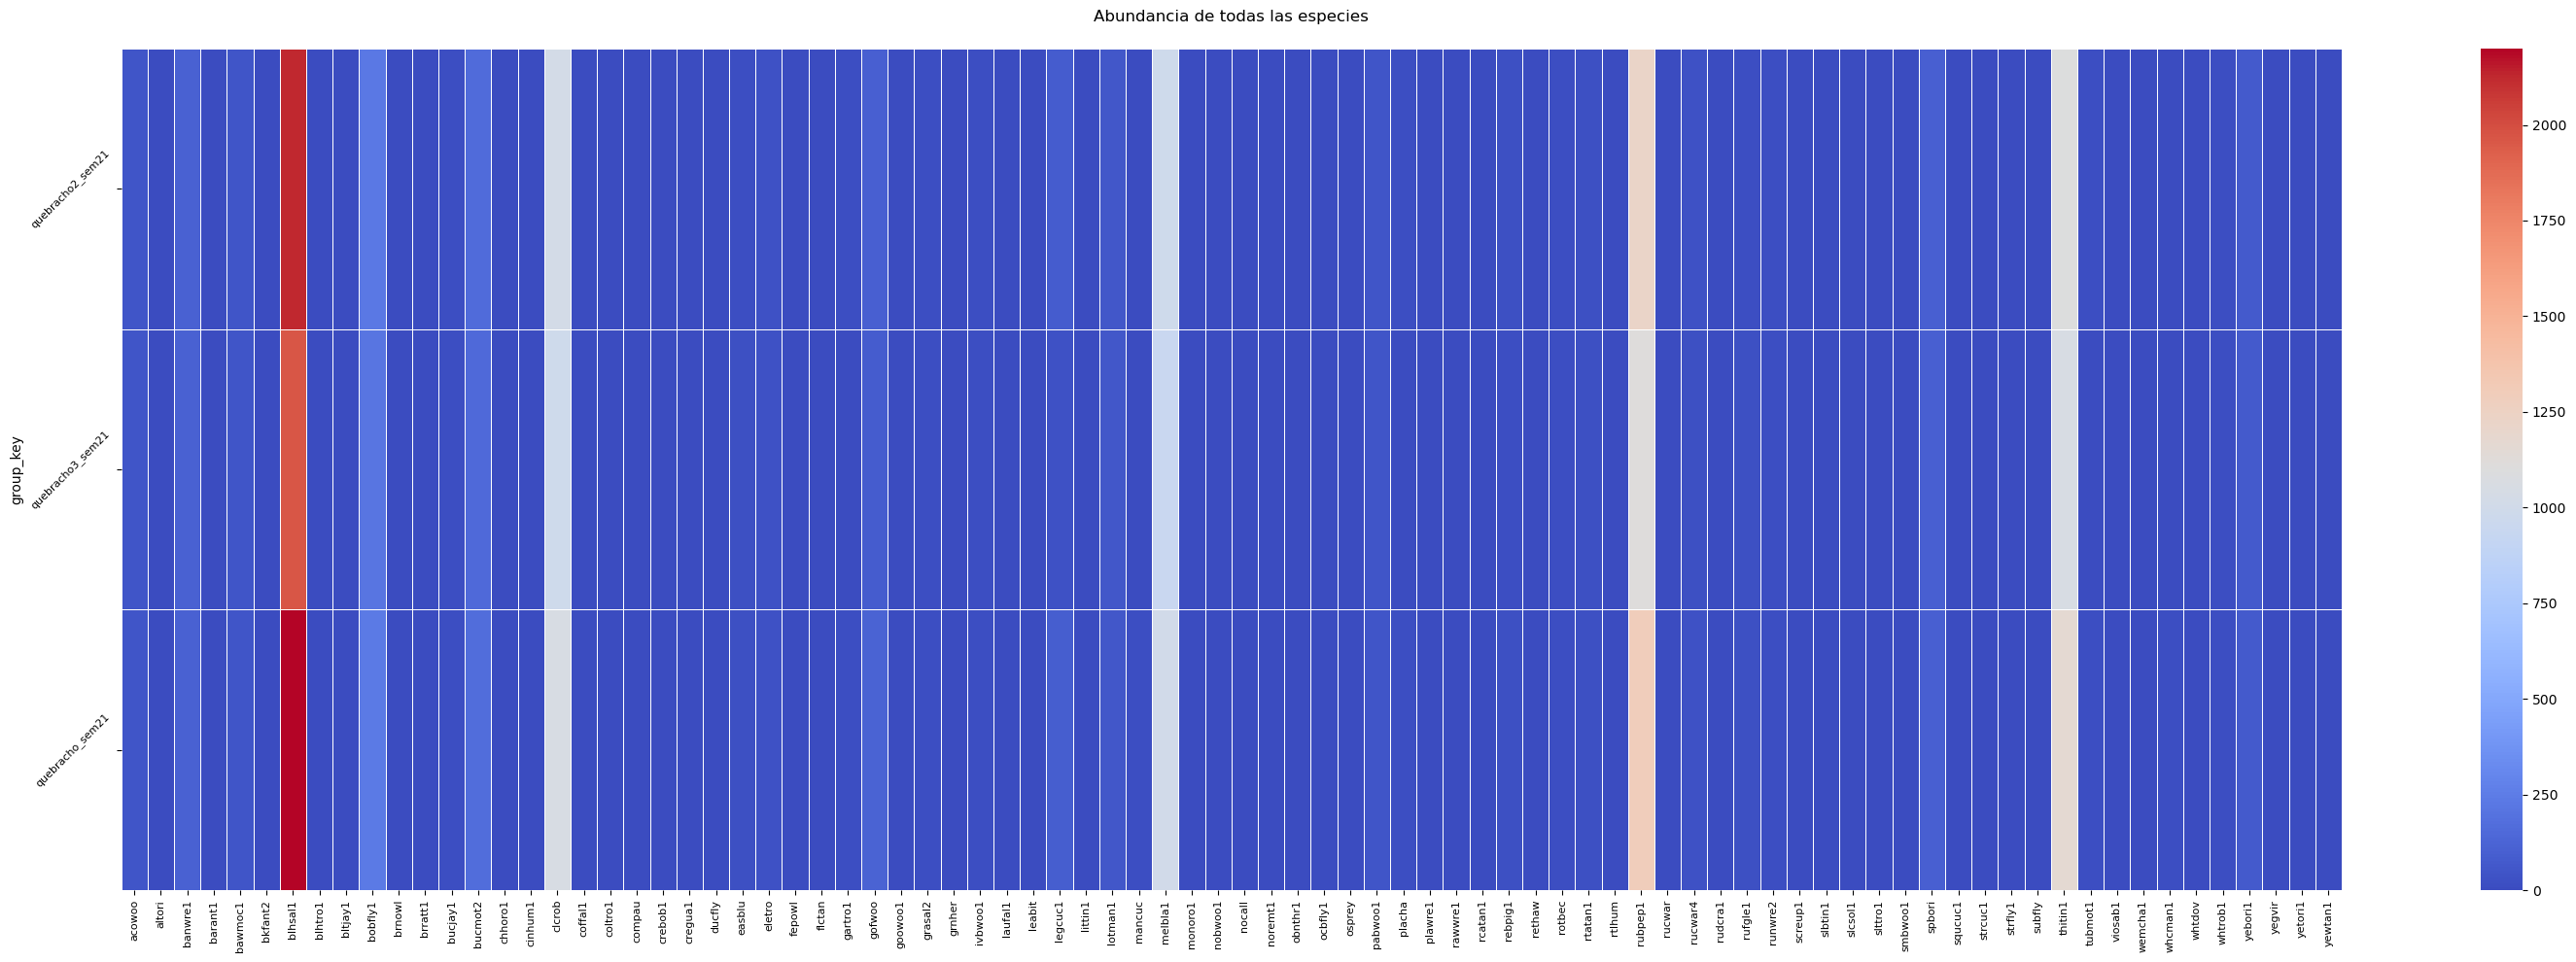

In [46]:
# Asumiendo que species_data es tu DataFrame
plt.figure(figsize=(30, 10))  # Tamaño grande

# Heatmap con ajustes
ax = sns.heatmap(
    species_data,
    annot=False,
    fmt="d",
    cmap="coolwarm",
    annot_kws={"size": 1},
    linewidths=0.5
)

# Rotar etiquetas y ajustar tamaño
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45,fontsize=8)

plt.title("Abundancia de todas las especies", pad=20)
plt.tight_layout()

# Create the filename using the group_key pattern
filename = f"images/heatmap.svg"
    
# Ensure the directory exists
import os
os.makedirs("images", exist_ok=True)
    
# Save the figure
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

In [47]:
df_merged3.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code',
       'Confidence', 'Begin Path', 'File Offset (s)', 'file_code', 'unique_id',
       'source_path', 'order', 'family', 'scientific name', 'English name',
       'category', 'Genus', 'species', 'IUCN_status', 'IUCN_response',
       'IUCN_category', 'fecha', 'hora_inicio', 'hora_canto', 'group_key'],
      dtype='object')

In [48]:
# Extraer pares únicos de especie y categoría IUCN
iucn_status = df_merged3[['Species Code', 'IUCN_category']].drop_duplicates()

# Convertir a Series (index: especie, valores: categoría IUCN)
iucn_status = iucn_status.set_index('Species Code')['IUCN_category']

# Verificar
print(iucn_status.head())

# Paleta de colores para cada categoría IUCN
iucn_palette = {
    "Not_IUCN": 'gray',
    "LC": "green",    # Least Concern
    "NT": "yellow",   # Near Threatened
    "VU": "orange",   # Vulnerable
    "EN": "red",      # Endangered
    "CR": "purple"    # Critically Endangered
}

Species Code
melbla1          LC
bobfly1          LC
nocall     Not_IUCN
clcrob           LC
whtrob1          LC
Name: IUCN_category, dtype: object


In [49]:
# species_data.columns debe contener los nombres comunes de las especies (mismo formato que en iucn_status)
iucn_colors = iucn_status.reindex(species_data.columns).map(iucn_palette).to_frame("IUCN")

In [50]:
sorted(iucn_status.dropna().unique())

['EN', 'LC', 'NT', 'Not_IUCN', 'VU']

In [51]:
assert species_data.isnull().sum().sum() == 0, "¡Hay valores nulos en species_data!"
assert (species_data.dtypes != 'object').all(), "species_data contiene columnas no numéricas"


In [52]:
#print("species_data.columns:", list(species_data.columns)[:5])
#print("iucn_colors.index:", list(iucn_colors.index)[:5])

<Figure size 2000x1000 with 0 Axes>

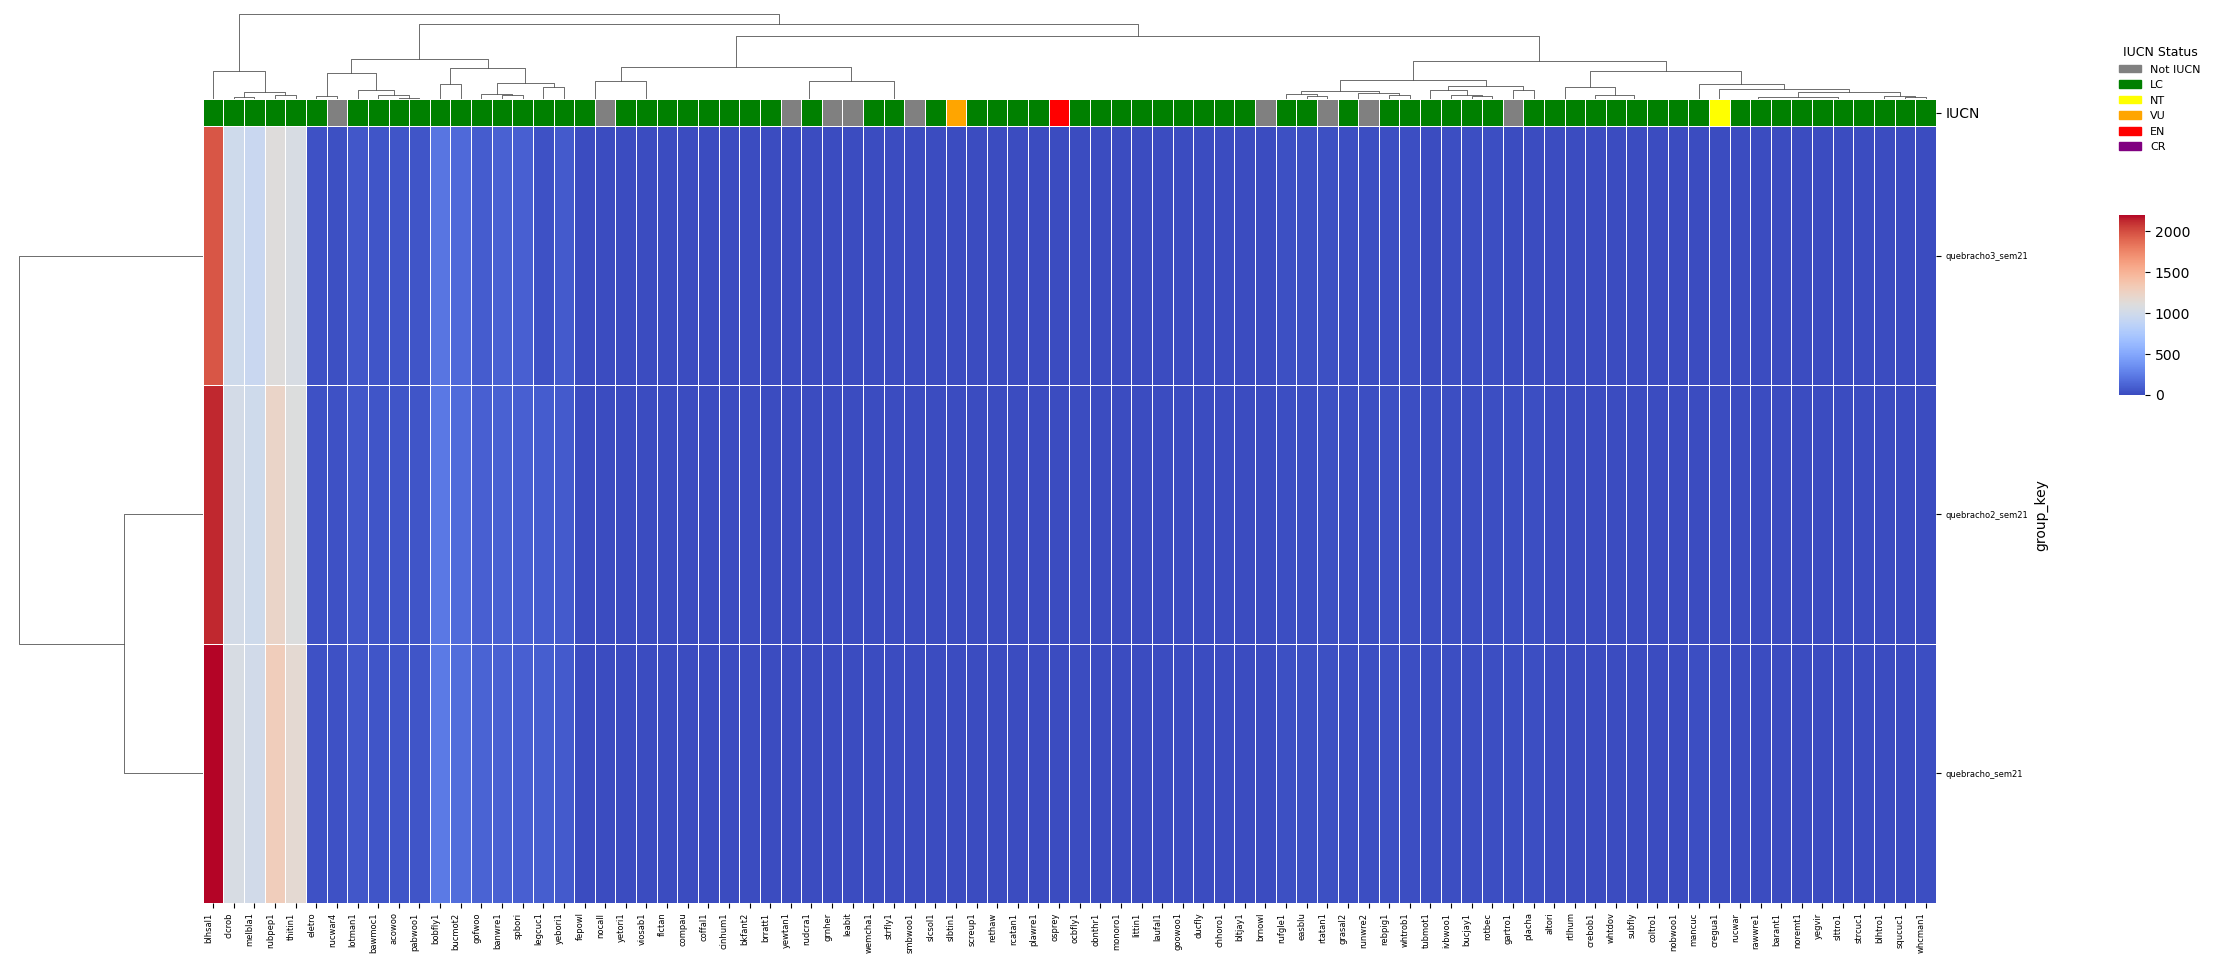

In [53]:
import matplotlib.patches as mpatches

iucn_colors = iucn_status.map(iucn_palette).to_frame("IUCN")

# 1. Configuración del clustermap
plt.figure(figsize=(20, 10))  # Ajusta según el número de especies

# 2. Clustermap con UPGMA (method='average')
g = sns.clustermap(
    species_data,
    method='average',          # UPGMA
    metric='braycurtis',       # Métrico para distancias (alternativas: 'euclidean', 'jaccard')
    cmap='coolwarm',            # Paleta de colores (mejor contraste que 'coolwarm')
    col_colors = iucn_colors.squeeze(),   # Barra de colores para especies
    figsize=(20, 10),          # Tamaño ajustable
    dendrogram_ratio=(0.1, 0.1),  # Espacio para dendrogramas
    cbar_pos=(1.062, 0.6, 0.013, 0.18),  # Posición de la barra de color
    yticklabels=True,          # Mostrar todas las etiquetas de filas
    xticklabels=True,          # Mostrar todas las etiquetas de columnas
    tree_kws={'linewidths': 0.5},  # Grosor de líneas del dendrograma
    linewidths=0.5,      # Grosor de las líneas
    linecolor='white', 
)

# 3. Ajustar etiquetas (rotación y tamaño)
plt.setp(g.ax_heatmap.get_xticklabels(), 
         rotation=90, 
         fontsize=6,           # Reducir tamaño para evitar solapamiento
         ha='right')           # Alinear a la derecha

plt.setp(g.ax_heatmap.get_yticklabels(), 
         rotation=0, 
         fontsize=6)

# 1. Definir los parches para cada categoría
legend_patches = [
    mpatches.Patch(color='gray', label='Not IUCN'),
    mpatches.Patch(color='green', label='LC'),
    mpatches.Patch(color='yellow', label='NT'),
    mpatches.Patch(color='orange', label='VU'),
    mpatches.Patch(color='red', label='EN'),
    mpatches.Patch(color='purple', label='CR')
]

# 2. Agregar leyenda al gráfico
g.ax_col_dendrogram.legend(
    handles=legend_patches,
    title="IUCN Status",
    loc='center left',
    bbox_to_anchor=(1.1, 0),
    frameon=False,
    fontsize=8,
    title_fontsize=9
)

# 4. Guardar en SVG (vectorial) y PNG
os.makedirs("images", exist_ok=True)
g.savefig(
    "images/heatmap-upgma.svg", 
    format='svg', 
    dpi=300, 
    bbox_inches='tight'
)

plt.show()
plt.close()


### CCA

In [54]:
matriz_abundancia = df_tidy.pivot(
    index='group_key',          # Filas: grupos/sitios
    columns='scientific name',  # Columnas: especies
    values='abundance'          # Valores: abundancias
).fillna(0)                     # Rellenar NaN con 0

# Eliminar nombres de ejes
matriz_abundancia.columns.name = None  # Elimina "scientific name" (columnas)
matriz_abundancia.index.name = None    # Elimina "group_key" (filas)

# Resultado limpio
matriz_abundancia

acowoo  altori  banwre1  barant1  bawmoc1  bkfant2  blhsal1  \
quebracho2_sem21      44       3      106        7       50        2     2128   
quebracho3_sem21      44       3      104        7       46        2     1961   
quebracho_sem21       44       3      110        7       50        2     2200   

                  blhtro1  bltjay1  bobfly1  ...  tubmot1  viosab1  wemcha1  \
quebracho2_sem21        7        1      229  ...       12        2        1   
quebracho3_sem21        8        1      207  ...        5        2        1   
quebracho_sem21         8        1      235  ...       12        2        1   

                  whcman1  whtdov  whtrob1  yebori1  yegvir  yetori1  yewtan1  
quebracho2_sem21        8       4       16       75       7        2        1  
quebracho3_sem21        8       4       14       69       6        2        0  
quebracho_sem21         9       4       17       75       7        2        1  

[3 rows x 84 columns]

In [55]:
# Example data (replace with your dataset)
# Example data
# Tipo de cobertura, habitat, cercania a cuerpos de agua, altitud, parcelas[riqueza, especies, dap, altura, cobertura]

env_data = pd.DataFrame({  # Environmental variables (samples x env)
    "pH": [2.0, 7.2, 9.1],
    "Temp": [1, 5, 25],
    "Alt": [1000, 2000, 2500],
}, index=matriz_abundancia.index)

In [56]:
from skbio.stats.ordination import cca



skbio.stats.ordination.cca(y, 
                           x, 
                           scaling=1, 
                           sample_ids=None, 
                           feature_ids=None, 
                           constraint_ids=None, 
                           output_format=None)


In [57]:
# Run CCA
cca_result = cca(
    y=matriz_abundancia,  # Species abundance matrix
    x=env_data,      # Environmental variables
    scaling=1        # Scaling type (1 focuses on species distances)
)

# Extract results
sample_scores = cca_result.samples  # Site scores in CCA space
species_scores = cca_result.features  # Species scores
env_scores = cca_result.biplot_scores  # Environmental variable arrows

print("Sample Scores (CCA):\n", sample_scores)
print("\nSpecies Scores:\n", species_scores)
print("\nEnvironmental Vectors:\n", env_scores)


Sample Scores (CCA):
                       CCA1      CCA2          CCA3          CCA4          CCA5
quebracho2_sem21 -0.027102 -0.014546 -4.044321e-16 -8.769115e-18 -1.755101e-17
quebracho3_sem21  0.071026  0.001479 -3.983700e-16 -4.563875e-17  1.160816e-17
quebracho_sem21  -0.037342  0.012649 -4.031971e-16  4.867791e-17  6.673736e-18

Species Scores:
               CCA1      CCA2      CCA3      CCA4      CCA5
acowoo    0.948209 -1.087234 -0.791634  0.708898 -0.344001
altori    0.948209 -1.087234 -0.823160  1.698597  2.294230
banwre1   0.548723  0.082498 -0.811275  0.247935 -0.565579
barant1   0.948209 -1.087234 -1.091726  0.895575  1.765966
bawmoc1   0.133240 -1.433646 -0.770450 -0.025631  0.228618
...            ...       ...       ...       ...       ...
whtrob1  -0.681120  0.500267 -1.044786 -0.916911 -0.670444
yebori1   0.133240 -1.433646 -0.451369  0.160170  0.517557
yegvir   -0.539110 -1.719435 -0.755429 -0.187083 -0.359366
yetori1   0.948209 -1.087234 -1.085315  0.841496 -0.53

In [58]:
# Convert env_scores to NumPy array if it's a DataFrame
env_scores_array = env_scores.values if hasattr(env_scores, 'values') else env_scores



In [59]:
#print("Number of CCA axes:", cca_result.scores.shape[1])
print("Number of CCA axes:", cca_result.features.shape[1])  # Species x CCA-axes
print("Number of CCA axes:", cca_result.biplot_scores.shape[1])  # Env-vars x CCA-axes

Number of CCA axes: 5
Number of CCA axes: 2


/tmp/ipykernel_36510/3539053207.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"CCA1 ({cca_result.proportion_explained[0] * 100:.1f}%)")
/tmp/ipykernel_36510/3539053207.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"CCA2 ({cca_result.proportion_explained[1] * 100:.1f}%)")


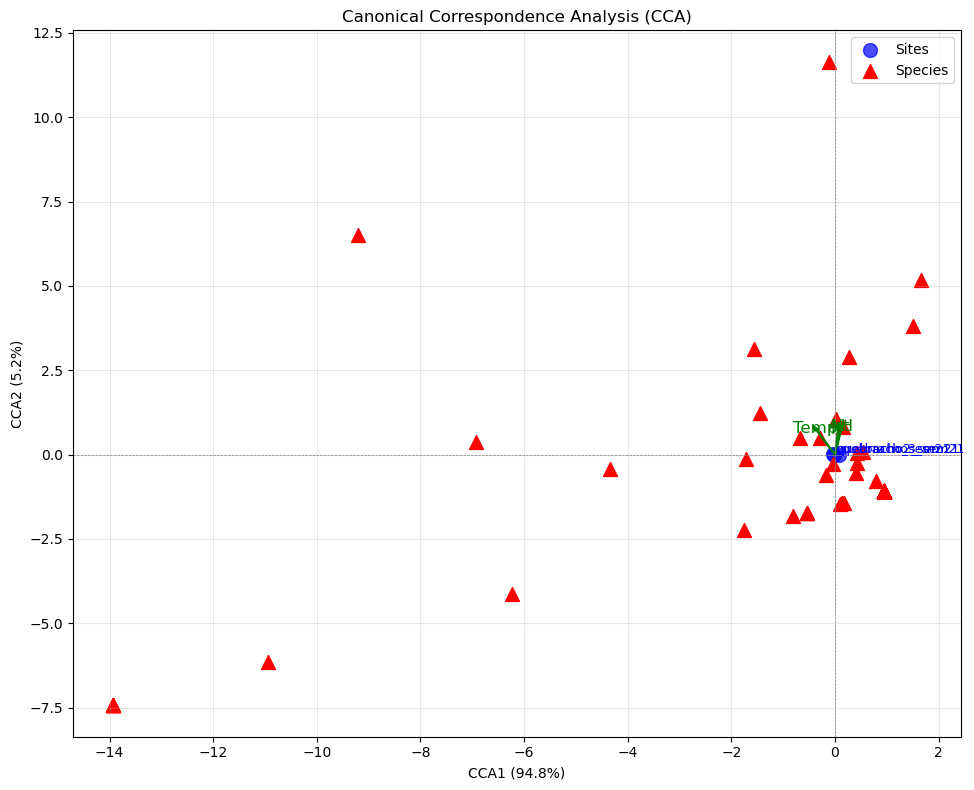

In [60]:
# Create the plot
plt.figure(figsize=(10, 8))

# Plot site scores (samples)
plt.scatter(
    sample_scores["CCA1"],
    sample_scores["CCA2"],
    color="blue",
    label="Sites",
    s=100,
    alpha=0.7
)

# Plot species scores
plt.scatter(
    species_scores["CCA1"],
    species_scores["CCA2"],
    color="red",
    label="Species",
    marker="^",
    s=100
)

# Plot environmental variable arrows (corrected indexing)
for i, var in enumerate(env_data.columns):
    plt.arrow(
        0, 0,
        env_scores_array[i, 0] * 0.8,  # Use env_scores_array instead
        env_scores_array[i, 1] * 0.8,
        color="green",
        width=0.02,
        head_width=0.1,
    )
    plt.text(
        env_scores_array[i, 0] * 0.85,
        env_scores_array[i, 1] * 0.85,
        var,
        color="green",
        fontsize=12,
        ha="center",
        va="center",
    )

# Add labels and legend
plt.xlabel(f"CCA1 ({cca_result.proportion_explained[0] * 100:.1f}%)")
plt.ylabel(f"CCA2 ({cca_result.proportion_explained[1] * 100:.1f}%)")
plt.title("Canonical Correspondence Analysis (CCA)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.grid(alpha=0.3)
plt.legend()

# Add site labels (optional)
for site in sample_scores.index:
    plt.text(
        sample_scores.loc[site, "CCA1"] + 0.05,
        sample_scores.loc[site, "CCA2"] + 0.05,
        site,
        fontsize=9,
        color="blue",
    )

plt.tight_layout()

# Create the filename using the group_key pattern
filename = f"images/cca.svg"
    
# Ensure the directory exists
os.makedirs("images", exist_ok=True)
    
# Save the figure
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

### RDA

In [61]:
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa_biplot

# PCoA
pcoa(distance_matrix, 
                            method='eigh', 
                            number_of_dimensions=0, 
                            inplace=False, 
                            seed=None, 
                            warn_neg_eigval=0.01, 
                            output_format=None)

In [62]:
# Compute Bray-Curtis distance matrix
distance_matrix = beta_diversity("braycurtis", matriz_abundancia)


In [63]:
pcoa_results = pcoa(
    distance_matrix,              # Your distance matrix
    method='eigh',                # Default: eigenvalue decomposition
    number_of_dimensions=0,       # 0 = keep all dimensions
    inplace=False,                # Do not modify input matrix
    seed=None,                    # Random seed (for reproducibility)
    warn_neg_eigval=0.01          # Return OrdinationResults object
)

In [64]:
# Coordenadas de las muestras en los ejes PCoA (DataFrame)
samples = pcoa_results.samples  # Columnas: 'PC1', 'PC2', etc.

# Valores propios (eigenvalues) y varianza explicada
eigenvalues = pcoa_results.eigvals          # Array de eigenvalues
variance_explained = pcoa_results.proportion_explained  # Varianza explicada por cada eje (ej: [0.5, 0.3, ...])

print("Coordenadas de las muestras:")
print(samples.head())
print("\nVarianza explicada por cada eje:", variance_explained)

Coordenadas de las muestras:
                       PC1       PC2  PC3
quebracho2_sem21  0.005913  0.003004  0.0
quebracho3_sem21 -0.031441 -0.001034  0.0
quebracho_sem21   0.025528 -0.001970  0.0

Varianza explicada por cada eje: PC1    0.991729
PC2    0.008271
PC3    0.000000
dtype: float64


/tmp/ipykernel_36510/3528152594.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(samples['PC1'][i], samples['PC2'][i], sample, fontsize=9)
/tmp/ipykernel_36510/3528152594.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({variance_explained[0]*100:.1f}%)")  # % varianza explicada
/tmp/ipykernel_36510/3528152594.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({variance_explaine

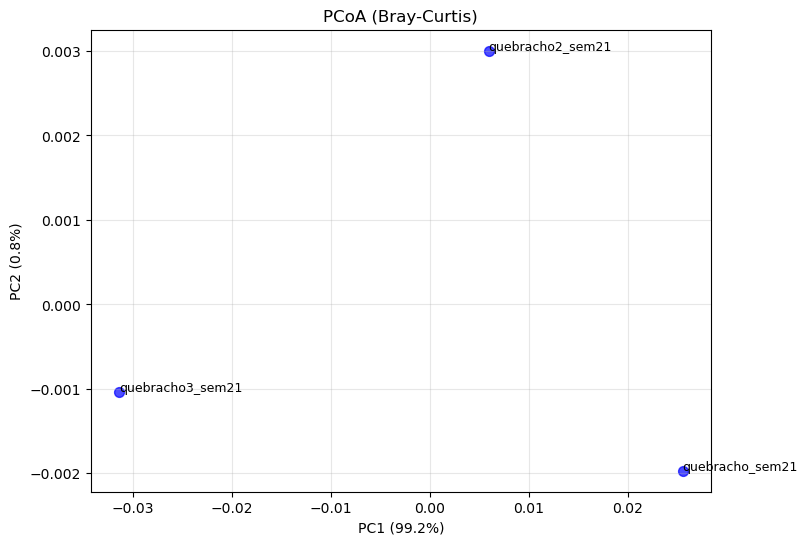

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(
    samples['PC1'],
    samples['PC2'],
    c='blue',                # Color de puntos
    s=50,                    # Tamaño de puntos
    alpha=0.7
)

# Etiquetar puntos (opcional)
for i, sample in enumerate(samples.index):
    plt.text(samples['PC1'][i], samples['PC2'][i], sample, fontsize=9)

plt.xlabel(f"PC1 ({variance_explained[0]*100:.1f}%)")  # % varianza explicada
plt.ylabel(f"PC2 ({variance_explained[1]*100:.1f}%)")
plt.title("PCoA (Bray-Curtis)")
plt.grid(alpha=0.3)
plt.show()

In [66]:
biplot_results = pcoa_biplot(pcoa_results, matriz_abundancia)

In [67]:
# Coordenadas de las muestras (ya las tienes en pcoa_results.samples)
samples = pcoa_results.samples[['PC1', 'PC2']]

# Coordenadas de las especies (features)
species = biplot_results.features[['PC1', 'PC2']]
species_coords = biplot_results.features[['PC1', 'PC2']]

/tmp/ipykernel_36510/2039328412.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_36510/2039328412.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


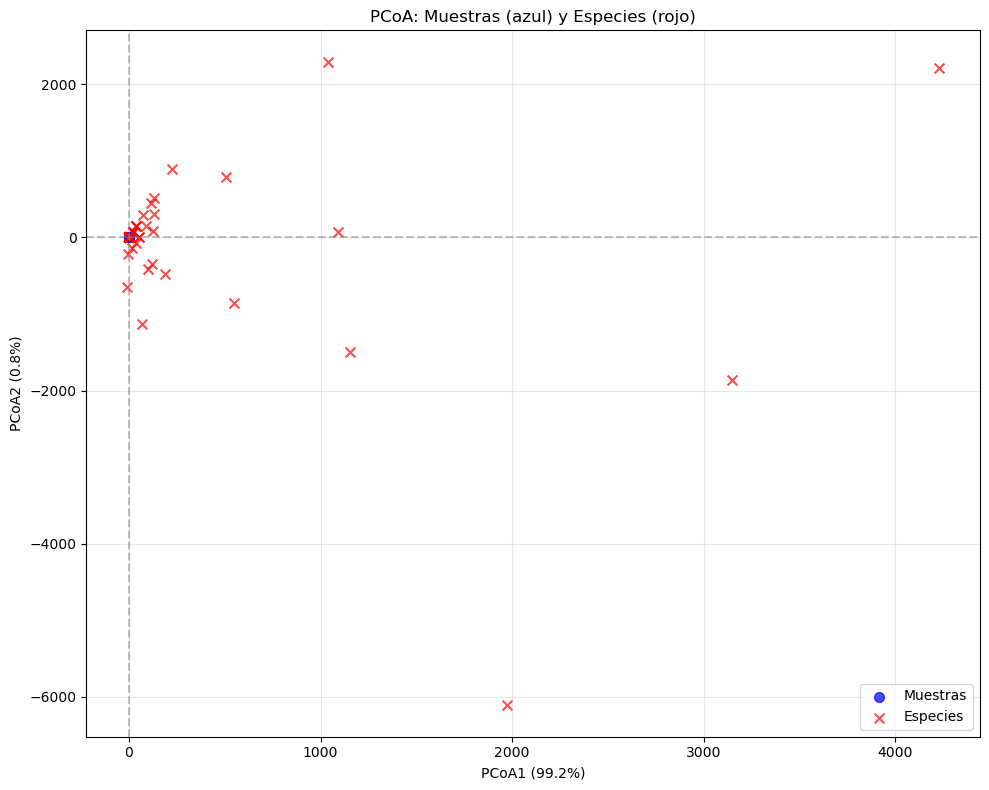

In [68]:
plt.figure(figsize=(10, 8))

# Muestras (puntos azules)
plt.scatter(
    pcoa_results.samples['PC1'],
    pcoa_results.samples['PC2'],
    c='blue',
    label='Muestras',
    alpha=0.7,
    s=50  # Tamaño de puntos
)

# Especies (puntos rojos)
plt.scatter(
    species_coords['PC1'],
    species_coords['PC2'],
    c='red',
    label='Especies',
    alpha=0.7,
    s=50,
    marker='x'  # Opcional: Usar 'x' en lugar de puntos
)

# Añadir líneas de referencia y estilo
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel(f"PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
plt.ylabel(f"PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")
plt.title("PCoA: Muestras (azul) y Especies (rojo)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()